<a href="https://colab.research.google.com/github/neddanedda/PyTorch_course/blob/main/Flowers_five_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flowers Five Classes from Kaggle


## Installing Kaggle and downloading the data

In [2]:
# ! pip install -q kaggle

In [2]:
# from google.colab import files

In [1]:
import os
from pathlib import Path
os.getcwd()

'/Users/neddacecchinato/Documents/Python/PyTorch_course'

In [3]:
os.chdir('../flowers_five_classes')
os.getcwd()

'/Users/neddacecchinato/Documents/Python/flowers_five_classes'

In [55]:
! kaggle datasets download -d lara311/flowers-five-classes

Dataset URL: https://www.kaggle.com/datasets/lara311/flowers-five-classes
License(s): apache-2.0
 99%|███████████████████████████████████████▊| 157M/158M [00:19<00:00, 9.77MB/s]
100%|████████████████████████████████████████| 158M/158M [00:19<00:00, 8.55MB/s]


In [57]:
path = Path("train/")
path.is_dir()

True

In [61]:
path = Path("train/")
if path.is_dir():
    print(f"Dataset already exists, skip extraction")
else:
    print(f"Unzipping file...")
    !unzip flowers-five-classes.zip;


Unzipping file...
Archive:  flowers-five-classes.zip
  inflating: train/daisy/10140303196_b88d3d6cec.jpg  
  inflating: train/daisy/10172379554_b296050f82_n.jpg  
  inflating: train/daisy/10172567486_2748826a8b.jpg  
  inflating: train/daisy/10172636503_21bededa75_n.jpg  
  inflating: train/daisy/10391248763_1d16681106_n.jpg  
  inflating: train/daisy/10437754174_22ec990b77_m.jpg  
  inflating: train/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: train/daisy/10437929963_bc13eebe0c.jpg  
  inflating: train/daisy/10466290366_cc72e33532.jpg  
  inflating: train/daisy/10466558316_a7198b87e2.jpg  
  inflating: train/daisy/10555749515_13a12a026e.jpg  
  inflating: train/daisy/10555815624_dc211569b0.jpg  
  inflating: train/daisy/10555826524_423eb8bf71_n.jpg  
  inflating: train/daisy/10559679065_50d2b16f6d.jpg  
  inflating: train/daisy/10712722853_5632165b04.jpg  
  inflating: train/daisy/10770585085_4742b9dac3_n.jpg  
  inflating: train/daisy/10841136265_af473efc60.jpg  
  inflating: tr

## Useful Functions


In [63]:
import random
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import shutil
import os

from pathlib import Path
from timeit import default_timer as timer
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
# from tqdm.auto import tqdm

In [11]:
# moving files back into train functions (they are moved away for a smaller model later in the code)
target_dir = ['train/rose/', 'train/sunflower/', 'train/tulip/']
source_dir = ['rose/', 'sunflower/', 'tulip/']

# create directory if they don't exist
for directory in target_dir:
    Path(directory).mkdir(parents=True, exist_ok=True)

for directory in range(3):
    if len(os.listdir(Path(target_dir[directory]))) == 0:
        file_names = os.listdir(source_dir[directory])
        print(len(file_names))
        print(f"{target_dir[directory]} is empty, moving files")
        for file_name in file_names:
            shutil.move(os.path.join(Path(source_dir[directory]), file_name), Path(target_dir[directory]))
        # os.rmdir(Path(source_dir[directory]))

498
train/rose/ is empty, moving files
495
train/sunflower/ is empty, moving files
607
train/tulip/ is empty, moving files


In [65]:
#check for gpu
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    device = "mps"
    print (x)
else:
    device = "cpu"
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [67]:
# synchronize time
torch.mps.synchronize()

In [69]:
from tqdm.notebook import tqdm

### Train step function

In [72]:
# %%writefile train_step.py
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               device: str ="cpu"):
    model.train()
    
    train_loss = 0
    train_acc = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # print(X.shape)
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y)
        # if batch % 10 == 0:
        #   print(f"Processed {batch} batches")

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc

In [74]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model_0.parameters(),
#                              lr=0.01)


In [76]:
# train_step(model_0,
#            train_dataloader,
#            optimizer,
#            loss_fn)

### Test step function

In [79]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: str ="cpu"):
    model.eval()
    
    test_loss = 0
    test_acc = 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y)
            y_pred_prob = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_prob == y).sum() / len(y)
            
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    
    return test_loss, test_acc

In [81]:
# test_step(model_0,
#           test_dataloader,
#           loss_fn)

### Train loop function

In [84]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module =nn.CrossEntropyLoss(),
          epochs: int =5,
          device: str="cpu"):
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model,
                                           train_dataloader,
                                           optimizer,
                                           loss_fn,
                                           device=device)
        test_loss, test_acc = test_step(model,
                                        test_dataloader,
                                        loss_fn,
                                        device=device)
    
        # if epochs <= 10:
        print(f"Epoch: {epoch+1}")
        print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.5f}")
        # else:
        #     if epoch % 5 == 0:
        #         print(f"Epoch: {epoch+1}")
        #         print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.5f}")

        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
    
    return results


### Confusion matrix function

In [87]:
# confusion matrix
try:
    import torchmetrics
except:
    !pip install -q torchmetrics
    import torchmetrics

try:
    import mlxtend
except:
    !pip install -q mlxtend
    import mlxtend

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [89]:
def confusion_matrix_plot(model: nn.Module,
                          test_dataloader: torch.utils.data.DataLoader,
                          class_names: list):
    # calculating the predictions on the test dataset
    device = next(model.parameters()).device
    model.eval()
    with torch.inference_mode():
        y_pred = []
        y_true = []
        for X, y in test_dataloader:
            y_logit = model(X.to(device))
            y_predictions = torch.softmax(y_logit.to("cpu"), dim=1).argmax(dim=1)
            y_pred.append(y_predictions)
            y_true.append(y)
        
        y_pred = torch.cat(y_pred)
        y_true = torch.cat(y_true)
    
    # calculating the confusion matrix
    confmat = ConfusionMatrix(task='multiclass',num_classes=len(class_names))
    confmat_tensor = confmat(preds=y_pred,
                             target=y_true).numpy()
    
    plot_confusion_matrix(confmat_tensor, class_names=class_names);


### Plotting model results

In [92]:
def plot_model_results(results: pd.DataFrame,
                       figsize: int=12):
    """ plotting train and test loss and accuracy over several epochs

    Args:
        results: a pd.DataFrame with 4 columns: train_loss, train_acc, test_loo, test_acc
        figsize1: figure width
        figsize2: figure height
    """
    
    plt.figure(figsize=(figsize, figsize))
    plt.subplot(2, 2, 1)
    plt.plot(range(len(results["train_loss"])), results["train_loss"])
    plt.plot(range(len(results["train_loss"])), results["test_loss"])
    plt.title("Loss")
    
    plt.subplot(2, 2, 2)
    plt.plot(range(len(results["train_loss"])), results["train_acc"])
    plt.plot(range(len(results["train_loss"])), results["test_acc"])
    plt.title("Accuracy")
    
    plt.subplot(2, 2, 3)
    plt.scatter(results["train_loss"], results["train_acc"])
    plt.title("Train loss vs train accuracy")
    
    plt.subplot(2, 2, 4)
    plt.scatter(results["test_loss"], results["test_acc"])
    plt.title("Test loss vs test accuracy");


### Plot random pictures from test data

In [95]:
def plot_random_test(model: torch.nn.Module,
                     test_data,
                     class_names,
                     total_pictures: int=4,
                     device: str="cpu"):
    random_pics = random.sample(range(len(test_data)), total_pictures)
    #
    model.eval()
    for pic in random_pics:
        picture = test_data[pic][0]
        true_class = test_data[pic][1]
        with torch.inference_mode():
            pred = torch.softmax(model(picture.to(device).unsqueeze(dim=0)),dim=1)
        plt.figure()
        plt.imshow(picture.permute(1, 2, 0))
        plt.title(f"True: {class_names[true_class]}, Pred: {class_names[torch.argmax(pred, dim=1)]}, Prob: {pred.max():.3f}")
        plt.axis(False);

### Saving model

In [98]:
def save_model(model: nn.Module,
               model_path: str):
    torch.save(obj=model.state_dict(),
               f=path(model_path))


## Importing the data and exploring

In [101]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [103]:
data = datasets.ImageFolder(root="train",
                            transform=data_transform, # transform for the data
                            target_transform=None)

In [54]:
class_names = data.classes

In [56]:
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [58]:
train_data, test_data = train_test_split(data, test_size=0.2)

In [60]:
len(train_data), len(test_data)

(2201, 551)

### Plotting some random images

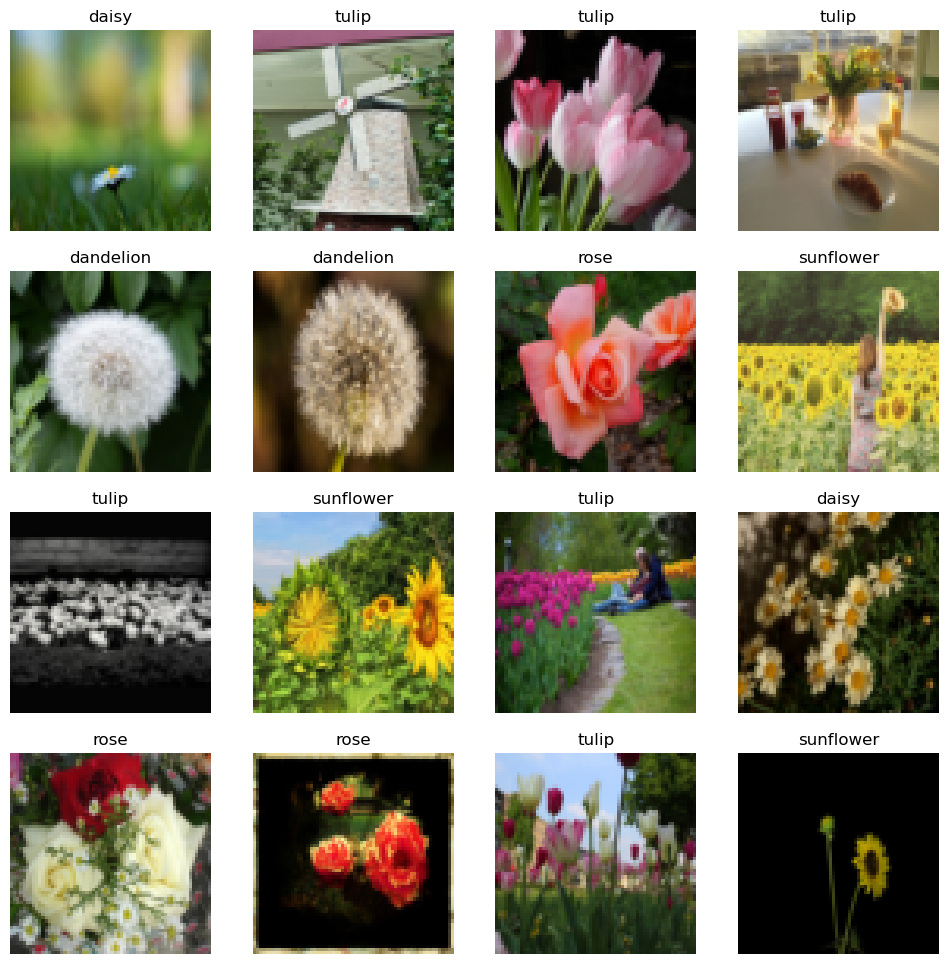

In [63]:
plt.figure(figsize=(12, 12))

for j in range(16):
  plt.subplot(4, 4, j+1)
  random_image = random.choice(range(len(test_data)))
  plt.imshow(train_data[random_image][0].permute(1, 2, 0))
  plt.title(class_names[train_data[random_image][1]])
  plt.axis(False);

### Creating dataloader for the model

In [66]:
# creating dataloader
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

In [68]:
len(train_dataloader)

69

In [70]:
train_data[0]

(tensor([[[0.8510, 0.9020, 0.8471,  ..., 0.7725, 0.8353, 0.6353],
          [0.7961, 0.8157, 0.8588,  ..., 0.8941, 0.8627, 0.7843],
          [0.8745, 0.8431, 0.9176,  ..., 0.8980, 0.8510, 0.7020],
          ...,
          [0.1137, 0.2667, 0.5922,  ..., 0.5765, 0.8157, 0.6118],
          [0.1020, 0.2000, 0.3137,  ..., 0.4471, 0.6863, 0.7255],
          [0.0784, 0.1333, 0.1529,  ..., 0.3294, 0.5098, 0.4902]],
 
         [[0.1608, 0.3529, 0.2510,  ..., 0.2745, 0.1843, 0.2588],
          [0.0392, 0.1059, 0.2078,  ..., 0.1961, 0.1961, 0.1216],
          [0.2078, 0.1804, 0.3725,  ..., 0.1961, 0.2039, 0.1098],
          ...,
          [0.1647, 0.0588, 0.0706,  ..., 0.0196, 0.3255, 0.1529],
          [0.2078, 0.0980, 0.0431,  ..., 0.0235, 0.2078, 0.1451],
          [0.2510, 0.1529, 0.1490,  ..., 0.0431, 0.1216, 0.1294]],
 
         [[0.4588, 0.5804, 0.5020,  ..., 0.4588, 0.4588, 0.3647],
          [0.3098, 0.3686, 0.4824,  ..., 0.4980, 0.4667, 0.3647],
          [0.4353, 0.4392, 0.5882,  ...,

In [72]:
# next(enumerate(train_dataloader))[0]

## Tiny VGG architecture

In [75]:
class TinyVGG(nn.Module):
  def __init__(self,
               in_feature: int,
               hidden_units: int,
               output_features: int,
               remaining_dimensions: int):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=in_feature,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*remaining_dimensions*remaining_dimensions,
                  out_features=output_features)
    )

  def forward(self, x):
    # x = self.conv_block1(x)
    # print(x.shape)
    # x = self.conv_block2(x)
    # print(x.shape)
    # x = self.classifier(x)
    # print(x.shape)
    # x = self.classifier1(x)
    # return(x)
    return self.classifier(
        self.conv_block2(self.conv_block1(x)))


In [77]:
model_0 = TinyVGG(3, 20, len(class_names), 13).to(device)
next(model_0.parameters()).device

device(type='mps', index=0)

## Model 0: Tiny VGG with 10 hidden units

In [80]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

In [82]:
summary(model_0, input_size=[32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 5]                   --
├─Sequential: 1-1                        [32, 20, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 20, 62, 62]          560
│    └─ReLU: 2-2                         [32, 20, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 20, 60, 60]          3,620
│    └─ReLU: 2-4                         [32, 20, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 20, 30, 30]          --
├─Sequential: 1-2                        [32, 20, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 20, 28, 28]          3,620
│    └─ReLU: 2-7                         [32, 20, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 20, 26, 26]          3,620
│    └─ReLU: 2-9                         [32, 20, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 20, 13, 13]          --
├─Seq

In [90]:
model_0 = TinyVGG(3, 10, 5, 13).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.01)

In [108]:
m0_start_time = timer()
model_0_results = train(model_0,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=20,
                        device="mps")
m0_end_time = timer()
print((m0_end_time-m0_start_time))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
Train loss: 0.48672 | Train acc: 0.81861 | Test loss: 1.81042 | Test acc: 0.45957
Epoch: 2
Train loss: 0.45769 | Train acc: 0.83109 | Test loss: 1.95445 | Test acc: 0.45858
Epoch: 3
Train loss: 0.45048 | Train acc: 0.83793 | Test loss: 2.01564 | Test acc: 0.44048
Epoch: 4
Train loss: 0.43669 | Train acc: 0.84674 | Test loss: 2.07009 | Test acc: 0.45337
Epoch: 5
Train loss: 0.42136 | Train acc: 0.84654 | Test loss: 1.90517 | Test acc: 0.47693
Epoch: 6
Train loss: 0.40489 | Train acc: 0.84757 | Test loss: 2.22474 | Test acc: 0.48313
Epoch: 7
Train loss: 0.37100 | Train acc: 0.86712 | Test loss: 2.25143 | Test acc: 0.46925
Epoch: 8
Train loss: 0.39761 | Train acc: 0.85062 | Test loss: 2.18071 | Test acc: 0.47098
Epoch: 9
Train loss: 0.37003 | Train acc: 0.87915 | Test loss: 2.24385 | Test acc: 0.45957
Epoch: 10
Train loss: 0.34335 | Train acc: 0.88574 | Test loss: 2.40114 | Test acc: 0.46032
Epoch: 11
Train loss: 0.34504 | Train acc: 0.87585 | Test loss: 2.32367 | Test acc: 0.472

In [109]:
model_0_results1 = train(model_0,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=40,
                        device=device)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1
Train loss: 0.26481 | Train acc: 0.91304 | Test loss: 3.17935 | Test acc: 0.45511
Epoch: 2
Train loss: 0.20245 | Train acc: 0.93505 | Test loss: 3.17575 | Test acc: 0.46925
Epoch: 3
Train loss: 0.20672 | Train acc: 0.92658 | Test loss: 3.42577 | Test acc: 0.45089
Epoch: 4
Train loss: 0.17450 | Train acc: 0.94482 | Test loss: 3.38211 | Test acc: 0.44296
Epoch: 5
Train loss: 0.21125 | Train acc: 0.93284 | Test loss: 3.26143 | Test acc: 0.46652
Epoch: 6
Train loss: 0.16578 | Train acc: 0.94824 | Test loss: 3.49148 | Test acc: 0.44469
Epoch: 7
Train loss: 0.17284 | Train acc: 0.94779 | Test loss: 3.39013 | Test acc: 0.44816
Epoch: 8
Train loss: 0.16740 | Train acc: 0.94248 | Test loss: 3.59323 | Test acc: 0.43080
Epoch: 9
Train loss: 0.18971 | Train acc: 0.95168 | Test loss: 5.15820 | Test acc: 0.41543
Epoch: 10
Train loss: 0.19267 | Train acc: 0.94565 | Test loss: 3.71894 | Test acc: 0.42733
Epoch: 11
Train loss: 0.11304 | Train acc: 0.97167 | Test loss: 3.94791 | Test acc: 0.436

In [112]:
import pandas as pd
model_0_results_total = pd.concat([pd.DataFrame(model_0_results),
                                   pd.DataFrame(model_0_results1)])
model_0_results_total.head()

,train_loss,train_acc,test_loss,test_acc
0,0.486717,0.818605,1.810424,0.459573
1,0.457692,0.831087,1.954449,0.458581
2,0.450478,0.837935,2.015638,0.440476
3,0.436690,0.846739,2.070086,0.453373
4,0.421356,0.846540,1.905170,0.476935


### Evaluating `model_0`

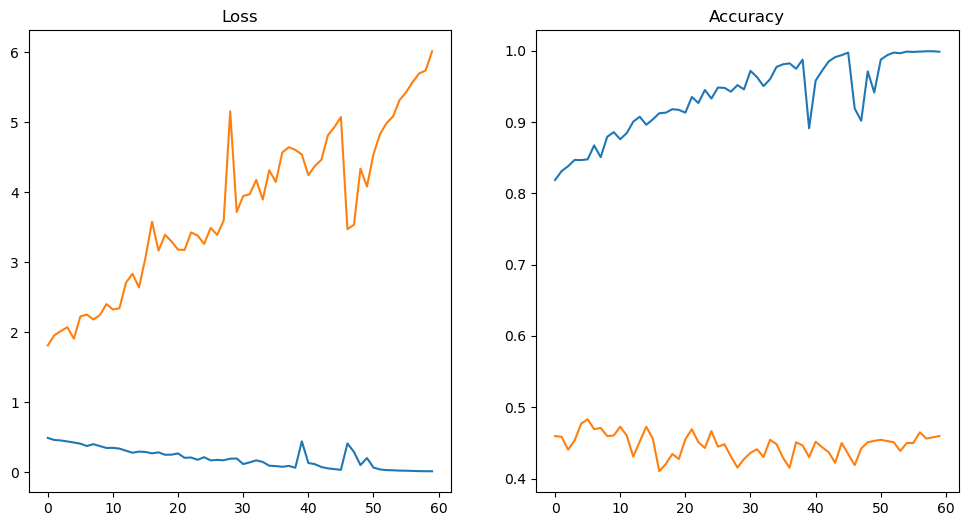

In [115]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["train_loss"])
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["test_loss"])
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["train_acc"])
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["test_acc"])
plt.title("Accuracy");


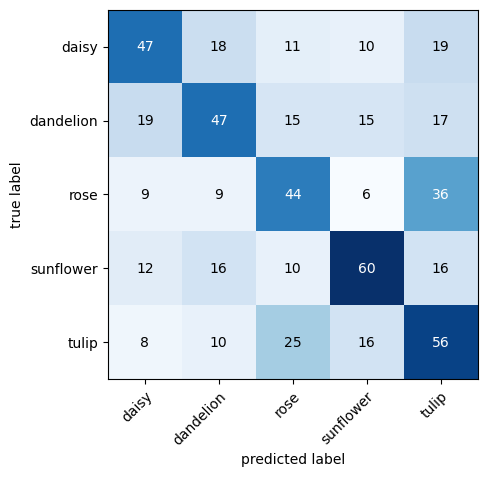

In [157]:
confusion_matrix_plot(model_0,
                      test_dataloader,
                      class_names)

## Model 1: Tiny VGG with 20 hidden units

In [159]:
model_1 = TinyVGG(3, 20, 5, 13).to(device)

In [161]:
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.01)

In [163]:
model_1_results = train(model_1,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=10,
                        device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60656 | Train acc: 0.22766 | Test loss: 1.61267 | Test acc: 0.20238
Epoch: 2
Train loss: 1.60185 | Train acc: 0.24190 | Test loss: 1.61531 | Test acc: 0.20238
Epoch: 3
Train loss: 1.60068 | Train acc: 0.24236 | Test loss: 1.61481 | Test acc: 0.20238
Epoch: 4
Train loss: 1.59904 | Train acc: 0.24447 | Test loss: 1.61476 | Test acc: 0.20238
Epoch: 5
Train loss: 1.59686 | Train acc: 0.24203 | Test loss: 1.61153 | Test acc: 0.20238
Epoch: 6
Train loss: 1.59201 | Train acc: 0.24435 | Test loss: 1.60644 | Test acc: 0.20238
Epoch: 7
Train loss: 1.58377 | Train acc: 0.24359 | Test loss: 1.59422 | Test acc: 0.23189
Epoch: 8
Train loss: 1.56347 | Train acc: 0.29313 | Test loss: 1.55676 | Test acc: 0.25967
Epoch: 9
Train loss: 1.52492 | Train acc: 0.30264 | Test loss: 1.50031 | Test acc: 0.29960
Epoch: 10
Train loss: 1.48513 | Train acc: 0.33571 | Test loss: 1.46525 | Test acc: 0.32316


In [164]:
model_1_results1 = train(model_1,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=50,
                        device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.45402 | Train acc: 0.36074 | Test loss: 1.46408 | Test acc: 0.34747
Epoch: 2
Train loss: 1.41213 | Train acc: 0.38442 | Test loss: 1.38694 | Test acc: 0.39162
Epoch: 3
Train loss: 1.34859 | Train acc: 0.42888 | Test loss: 1.31075 | Test acc: 0.43328
Epoch: 4
Train loss: 1.29681 | Train acc: 0.45746 | Test loss: 1.27830 | Test acc: 0.46379
Epoch: 5
Train loss: 1.24848 | Train acc: 0.46924 | Test loss: 1.25541 | Test acc: 0.45238
Epoch: 6
Train loss: 1.20860 | Train acc: 0.48560 | Test loss: 1.22727 | Test acc: 0.45957
Epoch: 7
Train loss: 1.19594 | Train acc: 0.48645 | Test loss: 1.21323 | Test acc: 0.46106
Epoch: 8
Train loss: 1.18144 | Train acc: 0.50127 | Test loss: 1.21872 | Test acc: 0.45064
Epoch: 9
Train loss: 1.16865 | Train acc: 0.51524 | Test loss: 1.19966 | Test acc: 0.46453
Epoch: 10
Train loss: 1.14693 | Train acc: 0.50708 | Test loss: 1.21177 | Test acc: 0.50025
Epoch: 11
Train loss: 1.13415 | Train acc: 0.52850 | Test loss: 1.20492 | Test acc: 0.463

In [167]:
model_1_results_total = pd.concat([pd.DataFrame(model_1_results),
                                   pd.DataFrame(model_1_results1)])

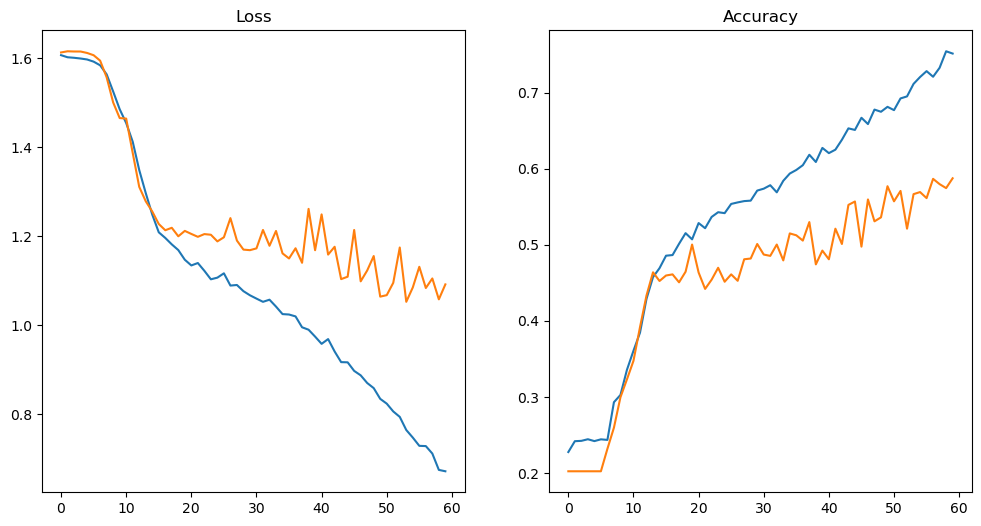

In [169]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["train_loss"])
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["test_loss"])
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["train_acc"])
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["test_acc"])
plt.title("Accuracy");


## Model 2: Tiny VGG with 40 hidden units

In [171]:
model_2 = TinyVGG(3, 40, 5, 13).to(device)

In [173]:
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.01)

In [175]:
model_2_results = train(model_2,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=10,
                        device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60594 | Train acc: 0.23141 | Test loss: 1.61069 | Test acc: 0.20238
Epoch: 2
Train loss: 1.60141 | Train acc: 0.24203 | Test loss: 1.61408 | Test acc: 0.20238
Epoch: 3
Train loss: 1.59942 | Train acc: 0.24266 | Test loss: 1.61359 | Test acc: 0.20238
Epoch: 4
Train loss: 1.59683 | Train acc: 0.24377 | Test loss: 1.61224 | Test acc: 0.20238
Epoch: 5
Train loss: 1.59251 | Train acc: 0.24241 | Test loss: 1.60509 | Test acc: 0.20238
Epoch: 6
Train loss: 1.58153 | Train acc: 0.26551 | Test loss: 1.58822 | Test acc: 0.20238
Epoch: 7
Train loss: 1.55325 | Train acc: 0.27263 | Test loss: 1.54025 | Test acc: 0.27778
Epoch: 8
Train loss: 1.49576 | Train acc: 0.33688 | Test loss: 1.46524 | Test acc: 0.34549
Epoch: 9
Train loss: 1.42806 | Train acc: 0.36806 | Test loss: 1.40755 | Test acc: 0.40030
Epoch: 10
Train loss: 1.34656 | Train acc: 0.40538 | Test loss: 1.31287 | Test acc: 0.41319


In [177]:
model_2_results1 = train(model_2,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=50,
                        device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.27036 | Train acc: 0.44906 | Test loss: 1.24870 | Test acc: 0.44816
Epoch: 2
Train loss: 1.21350 | Train acc: 0.48270 | Test loss: 1.21566 | Test acc: 0.42907
Epoch: 3
Train loss: 1.18866 | Train acc: 0.49428 | Test loss: 1.19845 | Test acc: 0.44196
Epoch: 4
Train loss: 1.16885 | Train acc: 0.50217 | Test loss: 1.21635 | Test acc: 0.44469
Epoch: 5
Train loss: 1.16561 | Train acc: 0.50784 | Test loss: 1.23063 | Test acc: 0.43056
Epoch: 6
Train loss: 1.14018 | Train acc: 0.52533 | Test loss: 1.18974 | Test acc: 0.45660
Epoch: 7
Train loss: 1.13503 | Train acc: 0.53051 | Test loss: 1.22655 | Test acc: 0.46528
Epoch: 8
Train loss: 1.11531 | Train acc: 0.54641 | Test loss: 1.19504 | Test acc: 0.45337
Epoch: 9
Train loss: 1.11683 | Train acc: 0.53833 | Test loss: 1.15288 | Test acc: 0.51761
Epoch: 10
Train loss: 1.11015 | Train acc: 0.54920 | Test loss: 1.41527 | Test acc: 0.40799
Epoch: 11
Train loss: 1.10703 | Train acc: 0.55361 | Test loss: 1.16218 | Test acc: 0.526

In [179]:
model_2_results_total = pd.concat([pd.DataFrame(model_2_results),
                                   pd.DataFrame(model_2_results1)])

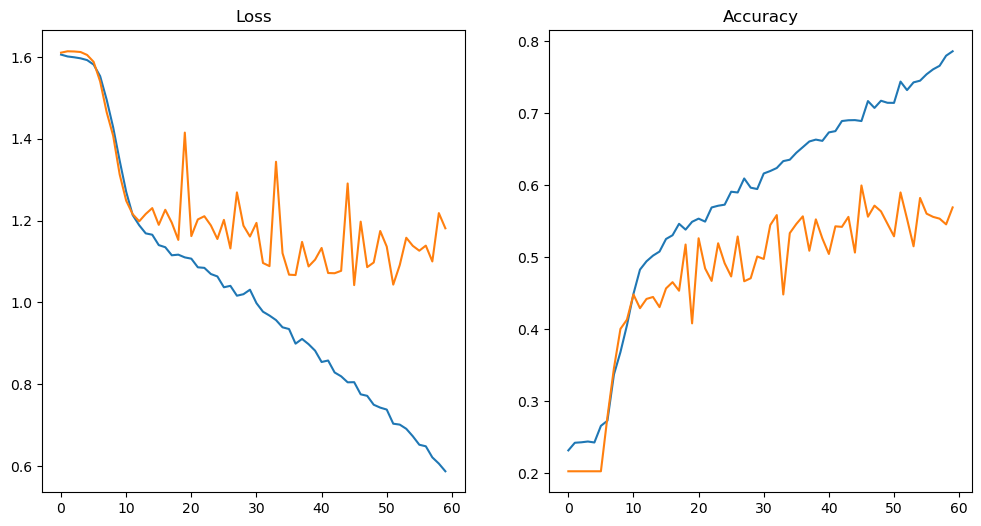

In [181]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["train_loss"])
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["test_loss"])
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["train_acc"])
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["test_acc"])
plt.title("Accuracy");


## Comparing Tiny VGG models with different hidden units

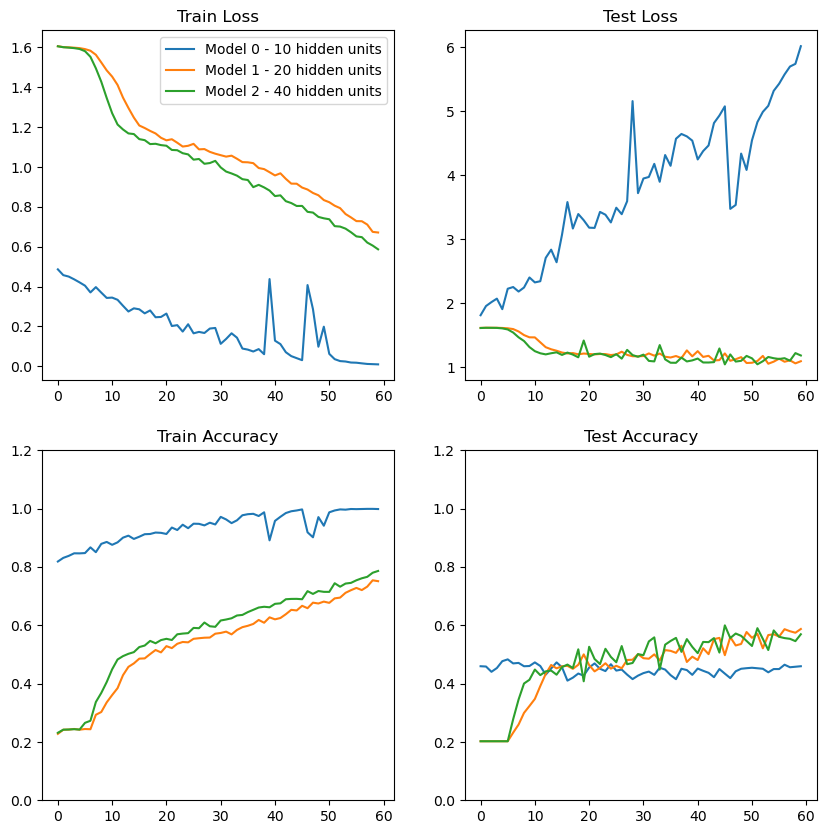

In [189]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["train_loss"], label="Model 0 - 10 hidden units")
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["train_loss"], label="Model 1 - 20 hidden units")
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["train_loss"], label="Model 2 - 40 hidden units")
plt.legend()
# plt.ylim(0, 3)
plt.title("Train Loss")

plt.subplot(2, 2, 2)
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["test_loss"])
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["test_loss"])
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["test_loss"])
# plt.ylim(0, 3)
plt.title("Test Loss")

plt.subplot(2, 2, 3)
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["train_acc"])
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["train_acc"])
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["train_acc"])
plt.ylim(0, 1.2)
plt.title("Train Accuracy");

plt.subplot(2, 2, 4)
plt.plot(range(len(model_0_results_total["train_loss"])), model_0_results_total["test_acc"])
plt.plot(range(len(model_1_results_total["train_loss"])), model_1_results_total["test_acc"])
plt.plot(range(len(model_2_results_total["train_loss"])), model_2_results_total["test_acc"])
plt.ylim(0, 1.2)
plt.title("Test Accuracy");

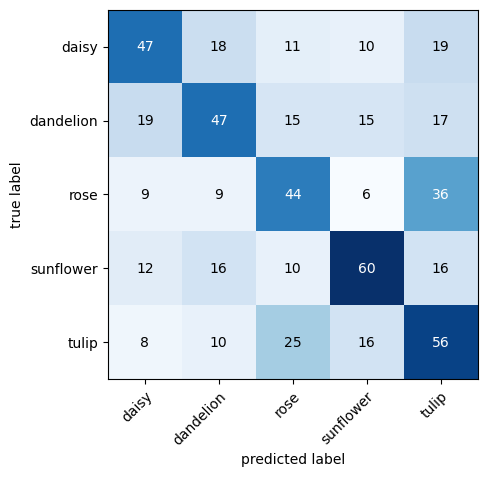

In [191]:
confusion_matrix_plot(model_0,
                      test_dataloader,
                      class_names)

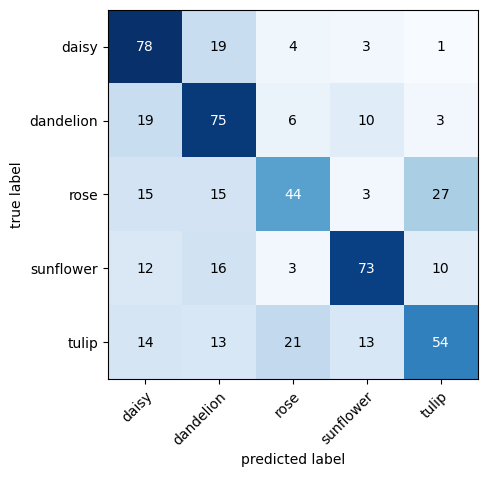

In [193]:
confusion_matrix_plot(model_1,
                      test_dataloader,
                      class_names)

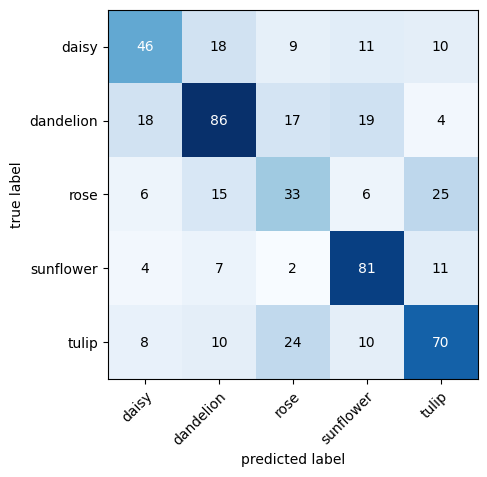

In [ ]:
confusion_matrix_plot(model_2,
                      test_dataloader,
                      class_names)

## VGG-11 architecture

https://www.geeksforgeeks.org/vgg-16-cnn-model/

In [140]:
class VGG11architecture(nn.Module):
    def __init__(self, classes: int=5):
        super().__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=512,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=classes)
            # nn.ReLU()
        )
        
    def forward(self, x):
        return self.classifier(self.convlayers(x))


### Importing data

https://debuggercafe.com/training-vgg11-from-scratch-using-pytorch/

In [247]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

In [303]:
data = datasets.ImageFolder(root="train",
                            transform=data_transform, # transform for the data
                            target_transform=None)

In [251]:
class_names = data.classes

In [253]:
torch.manual_seed(100)
train_data, test_data = train_test_split(data, test_size=0.05)
other_data, train_data = train_test_split(train_data, test_size=0.15)

In [254]:
len(train_data), len(test_data)

(393, 138)

In [255]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)
len(train_dataloader)

13

### Summary of finetuning exercises

The problem is always that the model is hugely underfitting with an accuracy below 25%. I only trained the model on a smaller dataset to see how it was doing:
* with an SGD optimizer:
    * I tried to increase the size of the dataset but did not see an improvement
    * I tried different learning rates and mixture of learning rates: see https://towardsdatascience.com/https-medium-com-dashingaditya-rakhecha-understanding-learning-rate-dd5da26bb6de
    * I tried to train for longer
    * I tried to use the entire dataset
* with an Adam optimizer:
    * no luck the loss does not improv
* starting with 2 categories only and add 1 category at a time while replacing the classifier of the model to increase the number of categories

Loss always gets stucked at around *1.6*.

So far nothing gave significant improvements

### Model 3: learning rate 0.01

In [258]:
model_3 = VGG11architecture().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(),
                            lr=0.001)

In [265]:
m3_start_time = timer()
model_3_results = train(model_3,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        epochs=10,
                        device=device)
m3_end_time = timer()
print((m3_end_time-m3_start_time)/60)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.72258 | Train acc: 0.19124 | Test loss: 1.60611 | Test acc: 0.28625
Epoch: 2
Train loss: 1.60835 | Train acc: 0.22756 | Test loss: 1.60306 | Test acc: 0.21000
Epoch: 3
Train loss: 1.60585 | Train acc: 0.23958 | Test loss: 1.61713 | Test acc: 0.16875
Epoch: 4
Train loss: 1.60585 | Train acc: 0.23958 | Test loss: 1.61406 | Test acc: 0.18250
Epoch: 5
Train loss: 1.60541 | Train acc: 0.23958 | Test loss: 1.60470 | Test acc: 0.21000
Epoch: 6
Train loss: 1.60241 | Train acc: 0.23958 | Test loss: 1.61256 | Test acc: 0.16875
Epoch: 7
Train loss: 1.60453 | Train acc: 0.24573 | Test loss: 1.61343 | Test acc: 0.19625
Epoch: 8
Train loss: 1.60635 | Train acc: 0.23344 | Test loss: 1.60949 | Test acc: 0.21000
Epoch: 9
Train loss: 1.60740 | Train acc: 0.22115 | Test loss: 1.60984 | Test acc: 0.19625
Epoch: 10
Train loss: 1.60457 | Train acc: 0.23958 | Test loss: 1.60927 | Test acc: 0.21000
2.217924959034038


In [267]:
m3_start_time = timer()
model_3_results1 = train(model_3,
                         train_dataloader,
                         test_dataloader,
                         optimizer,
                         epochs=20,
                         device=device)
m3_end_time = timer()
print((m3_end_time-m3_start_time)/60)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60345 | Train acc: 0.24332 | Test loss: 1.60030 | Test acc: 0.22375
Epoch: 2
Train loss: 1.60847 | Train acc: 0.22115 | Test loss: 1.60981 | Test acc: 0.18250
Epoch: 3
Train loss: 1.60476 | Train acc: 0.24573 | Test loss: 1.60230 | Test acc: 0.22375
Epoch: 4
Train loss: 1.60780 | Train acc: 0.22730 | Test loss: 1.60303 | Test acc: 0.19625
Epoch: 5
Train loss: 1.60510 | Train acc: 0.24573 | Test loss: 1.60533 | Test acc: 0.19625
Epoch: 6
Train loss: 1.60221 | Train acc: 0.25187 | Test loss: 1.60951 | Test acc: 0.19625
Epoch: 7
Train loss: 1.59974 | Train acc: 0.25801 | Test loss: 1.61624 | Test acc: 0.18250
Epoch: 8
Train loss: 1.60488 | Train acc: 0.23958 | Test loss: 1.61850 | Test acc: 0.18250
Epoch: 9
Train loss: 1.60226 | Train acc: 0.23958 | Test loss: 1.60552 | Test acc: 0.21000
Epoch: 10
Train loss: 1.60241 | Train acc: 0.24573 | Test loss: 1.61052 | Test acc: 0.18250
Epoch: 11
Train loss: 1.60372 | Train acc: 0.24573 | Test loss: 1.60996 | Test acc: 0.196

In [273]:
optimizer = torch.optim.Adam(model_3.parameters(),
                            lr=0.0001)
m3_start_time = timer()
model_3_results2 = train(model_3,
                         train_dataloader,
                         test_dataloader,
                         optimizer,
                         epochs=200,
                         device=device)
m3_end_time = timer()
print((m3_end_time-m3_start_time)/60)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60259 | Train acc: 0.23718 | Test loss: 1.60655 | Test acc: 0.16875
Epoch: 2
Train loss: 1.60561 | Train acc: 0.23958 | Test loss: 1.60510 | Test acc: 0.19625
Epoch: 3
Train loss: 1.60459 | Train acc: 0.23958 | Test loss: 1.60334 | Test acc: 0.18250
Epoch: 4
Train loss: 1.60421 | Train acc: 0.23344 | Test loss: 1.60583 | Test acc: 0.18250
Epoch: 5
Train loss: 1.60329 | Train acc: 0.23344 | Test loss: 1.61407 | Test acc: 0.16875
Epoch: 6
Train loss: 1.60525 | Train acc: 0.23718 | Test loss: 1.60668 | Test acc: 0.19625
Epoch: 7
Train loss: 1.60489 | Train acc: 0.22489 | Test loss: 1.60294 | Test acc: 0.22375
Epoch: 8
Train loss: 1.60487 | Train acc: 0.22730 | Test loss: 1.60763 | Test acc: 0.19625
Epoch: 9
Train loss: 1.60651 | Train acc: 0.23344 | Test loss: 1.60544 | Test acc: 0.19625
Epoch: 10
Train loss: 1.60449 | Train acc: 0.22730 | Test loss: 1.60250 | Test acc: 0.22375
Epoch: 11
Train loss: 1.60624 | Train acc: 0.22730 | Test loss: 1.61161 | Test acc: 0.168

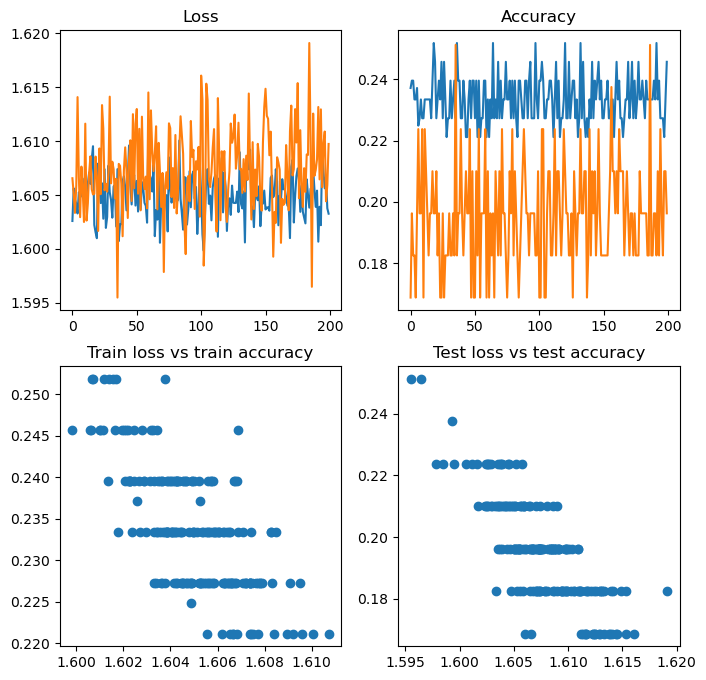

In [277]:
model_3_all_results = pd.concat([#pd.DataFrame(model_3_results),
                                 #pd.DataFrame(model_3_results1),
                                 pd.DataFrame(model_3_results2)])
plot_model_results(model_3_all_results, 8)

In [206]:
# m3_start_time = timer()
# # model_3_results = []
# model_3_results = pd.DataFrame()

# for cycle in range(5):
#     optimizer = torch.optim.SGD(model_3.parameters(),
#                                 lr=0.01)
#     model_3_results0 = train(model_3,
#                              train_dataloader,
#                              test_dataloader,
#                              optimizer,
#                              epochs=5,
#                              device=device)
#     optimizer = torch.optim.SGD(model_3.parameters(),
#                                 lr=0.005)
#     model_3_results1 = train(model_3,
#                              train_dataloader,
#                              test_dataloader,
#                              optimizer,
#                              epochs=5,
#                              device=device)
#     optimizer = torch.optim.SGD(model_3.parameters(),
#                                 lr=0.001)
#     model_3_results2 = train(model_3,
#                              train_dataloader,
#                              test_dataloader,
#                              optimizer,
#                              epochs=5,
#                              device=device)
#     model_3_results = pd.concat([model_3_results,
#                                  pd.DataFrame(model_3_results0),
#                                  pd.DataFrame(model_3_results1),
#                                  pd.DataFrame(model_3_results2)])

# m3_end_time = timer()
# print((m3_end_time-m3_start_time)/60)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60329 | Train acc: 0.23964 | Test loss: 1.60501 | Test acc: 0.21726


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60249 | Train acc: 0.23976 | Test loss: 1.60638 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60224 | Train acc: 0.24027 | Test loss: 1.60059 | Test acc: 0.22966


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60265 | Train acc: 0.23938 | Test loss: 1.60655 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60229 | Train acc: 0.23976 | Test loss: 1.60560 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60217 | Train acc: 0.24040 | Test loss: 1.60649 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60237 | Train acc: 0.23976 | Test loss: 1.60558 | Test acc: 0.22346


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60251 | Train acc: 0.23951 | Test loss: 1.60668 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60229 | Train acc: 0.23976 | Test loss: 1.60935 | Test acc: 0.20486


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60246 | Train acc: 0.23976 | Test loss: 1.60372 | Test acc: 0.21726


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60214 | Train acc: 0.24078 | Test loss: 1.60446 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60219 | Train acc: 0.24040 | Test loss: 1.60766 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60248 | Train acc: 0.24002 | Test loss: 1.60317 | Test acc: 0.22346


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60241 | Train acc: 0.23964 | Test loss: 1.60451 | Test acc: 0.21106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60224 | Train acc: 0.24027 | Test loss: 1.60414 | Test acc: 0.22346
68.89986470695003


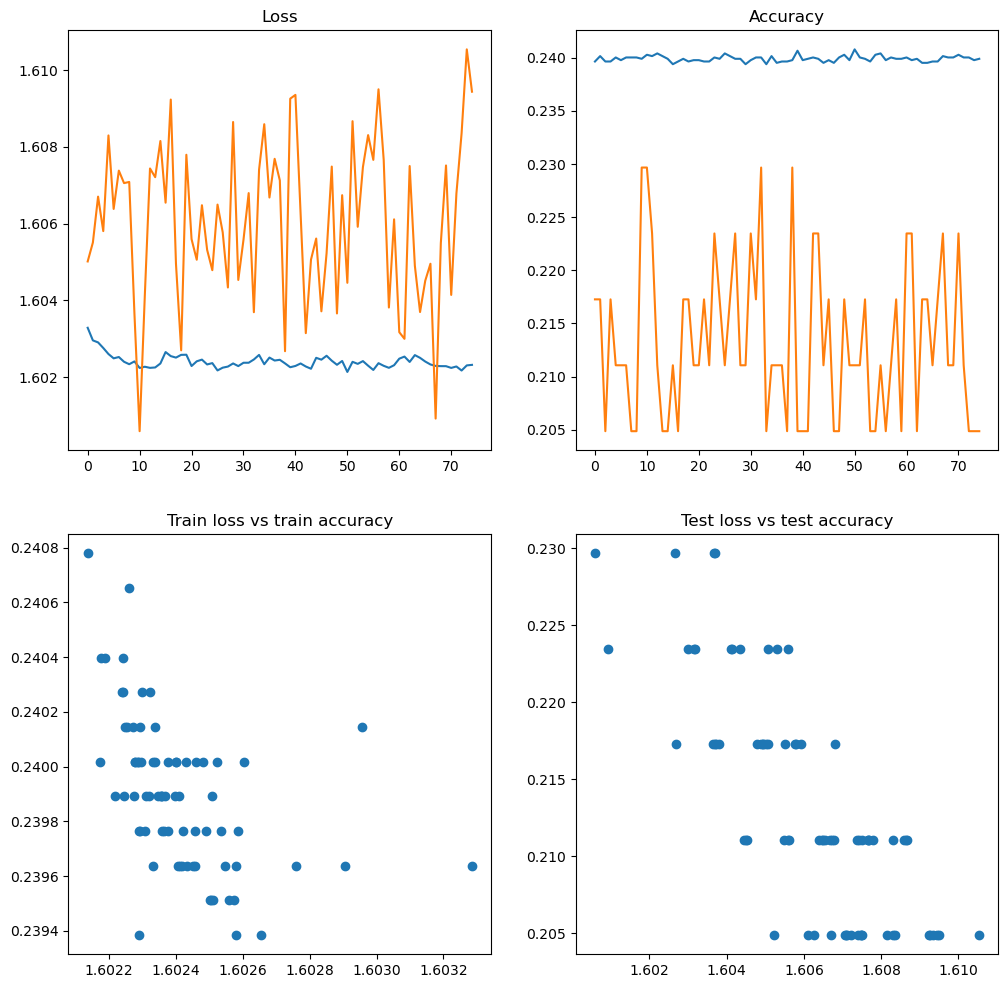

In [209]:
plot_model_results(model_3_results)

In [ ]:
from pathlib import Path
MODEL_PATH = Path("flowers_five_classes")
MODEL_NAME = "vgg11_five_flowers_10_epochs.pth"
RESULT_PATH = MODEL_PATH / "vgg11_summary_results.pickle"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
# save the model
torch.save(obj=model_3.state_dict(),
           f=MODEL_NAME)

In [206]:
with open('vgg11_summary_results.pickle', 'wb') as handle:
    pickle.dump(model_3_results, handle)

In [ ]:
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.001)

### Model 4: learning rate 0.001

In [218]:
model_4 = VGG11architecture().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.001)

In [220]:
model_4_results = train(model_4,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        epochs=1,
                        device=device)

model_4_results = pd.DataFrame(model_4_results)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60862 | Train acc: 0.21933 | Test loss: 1.60919 | Test acc: 0.21007


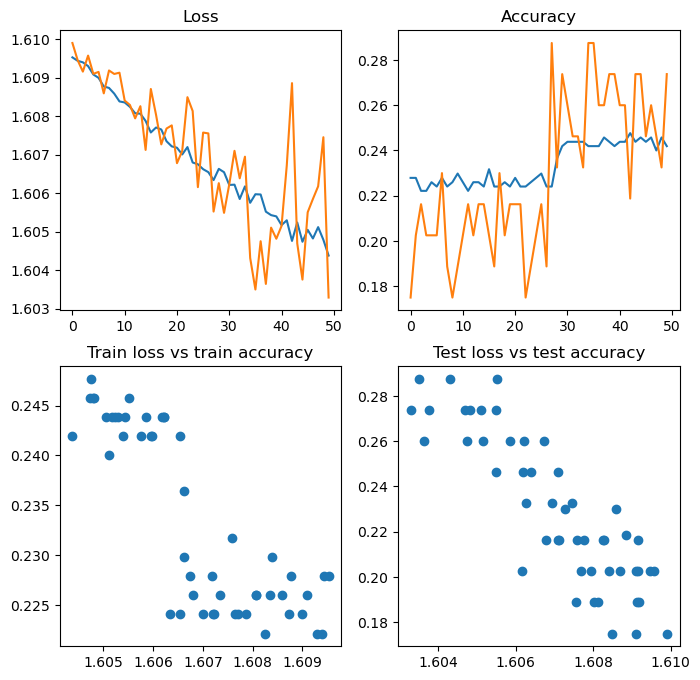

In [342]:
plot_model_results(model_4_results, figsize=8)

### Model 5: changing learning rate

* first 20 epochs learning rate $lr=0.01$
* after 20 epochs move learning rate to $lr=0.001$

In [370]:
model_5 = VGG11architecture()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_5.parameters(),
                            lr=0.01)

In [372]:
m5_start_time = timer()
model_5_results = train(model_5,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        epochs=20)
m5_end_time = timer()
print(m5_end_time-m5_start_time)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.60751 | Train acc: 0.20877 | Test loss: 1.60953 | Test acc: 0.12500
Epoch: 2
Train loss: 1.60636 | Train acc: 0.22952 | Test loss: 1.61130 | Test acc: 0.13021
Epoch: 3
Train loss: 1.60540 | Train acc: 0.24842 | Test loss: 1.61079 | Test acc: 0.13021
Epoch: 4
Train loss: 1.60438 | Train acc: 0.24711 | Test loss: 1.61251 | Test acc: 0.12500
Epoch: 5
Train loss: 1.60355 | Train acc: 0.24842 | Test loss: 1.61263 | Test acc: 0.13021
Epoch: 6
Train loss: 1.60279 | Train acc: 0.24895 | Test loss: 1.61348 | Test acc: 0.12500
Epoch: 7
Train loss: 1.60205 | Train acc: 0.24842 | Test loss: 1.61310 | Test acc: 0.11979
Epoch: 8
Train loss: 1.60148 | Train acc: 0.24869 | Test loss: 1.61344 | Test acc: 0.13021
Epoch: 9
Train loss: 1.60077 | Train acc: 0.24895 | Test loss: 1.61584 | Test acc: 0.13021
Epoch: 10
Train loss: 1.60039 | Train acc: 0.24895 | Test loss: 1.61465 | Test acc: 0.12500
Epoch: 11
Train loss: 1.59962 | Train acc: 0.24921 | Test loss: 1.61270 | Test acc: 0.140

In [377]:
print((m5_end_time-m5_start_time)/60)

25.993916598616245


In [379]:
optimizer = torch.optim.SGD(model_5.parameters(),
                            lr=0.001)

m5_start_time = timer()
model_5_results1 = train(model_5,
                         train_dataloader,
                         test_dataloader,
                         optimizer,
                         epochs=20)
m5_end_time = timer()
print((m5_end_time-m5_start_time)/60)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59702 | Train acc: 0.24711 | Test loss: 1.62065 | Test acc: 0.12500
Epoch: 2
Train loss: 1.59685 | Train acc: 0.24790 | Test loss: 1.62363 | Test acc: 0.11979
Epoch: 3
Train loss: 1.59679 | Train acc: 0.24842 | Test loss: 1.62207 | Test acc: 0.11458
Epoch: 4
Train loss: 1.59694 | Train acc: 0.24790 | Test loss: 1.62175 | Test acc: 0.13021
Epoch: 5
Train loss: 1.59664 | Train acc: 0.24737 | Test loss: 1.61987 | Test acc: 0.11979
Epoch: 6
Train loss: 1.59658 | Train acc: 0.24737 | Test loss: 1.61788 | Test acc: 0.13021
Epoch: 7
Train loss: 1.59687 | Train acc: 0.24737 | Test loss: 1.62257 | Test acc: 0.11979
Epoch: 8
Train loss: 1.59691 | Train acc: 0.24790 | Test loss: 1.61827 | Test acc: 0.13542
Epoch: 9
Train loss: 1.59656 | Train acc: 0.24895 | Test loss: 1.62301 | Test acc: 0.11458
Epoch: 10
Train loss: 1.59685 | Train acc: 0.24737 | Test loss: 1.61972 | Test acc: 0.12500
Epoch: 11
Train loss: 1.59671 | Train acc: 0.24764 | Test loss: 1.62038 | Test acc: 0.135

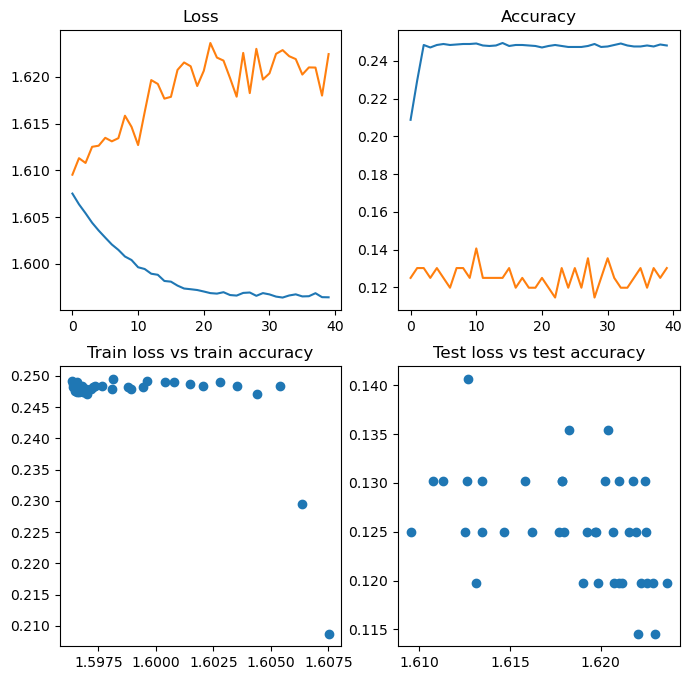

In [383]:
model_5_all_results = pd.concat([
    pd.DataFrame(model_5_results),
    pd.DataFrame(model_5_results1)])
plot_model_results(model_5_all_results, figsize=8)

In [385]:
train_data, test_data = train_test_split(data, test_size=0.05)
other_data, train_data = train_test_split(train_data, test_size=0.25)

In [387]:
m5_start_time = timer()
model_5_results2 = train(model_5,
                         train_dataloader,
                         test_dataloader,
                         optimizer,
                         epochs=10)
m5_end_time = timer()
print((m5_end_time-m5_start_time)/60)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train loss: 1.59628 | Train acc: 0.24816 | Test loss: 1.62110 | Test acc: 0.13021
Epoch: 2
Train loss: 1.59659 | Train acc: 0.24685 | Test loss: 1.61356 | Test acc: 0.14062
Epoch: 3
Train loss: 1.59626 | Train acc: 0.24842 | Test loss: 1.62776 | Test acc: 0.11458
Epoch: 4
Train loss: 1.59621 | Train acc: 0.24842 | Test loss: 1.62234 | Test acc: 0.11458
Epoch: 5
Train loss: 1.59641 | Train acc: 0.24790 | Test loss: 1.62199 | Test acc: 0.11979
Epoch: 6
Train loss: 1.59627 | Train acc: 0.24816 | Test loss: 1.62131 | Test acc: 0.13021
Epoch: 7
Train loss: 1.59644 | Train acc: 0.24842 | Test loss: 1.62068 | Test acc: 0.11979
Epoch: 8
Train loss: 1.59640 | Train acc: 0.24790 | Test loss: 1.62175 | Test acc: 0.12500
Epoch: 9
Train loss: 1.59639 | Train acc: 0.24790 | Test loss: 1.61894 | Test acc: 0.13542
Epoch: 10
Train loss: 1.59630 | Train acc: 0.24790 | Test loss: 1.62183 | Test acc: 0.12500
12.987516863883744


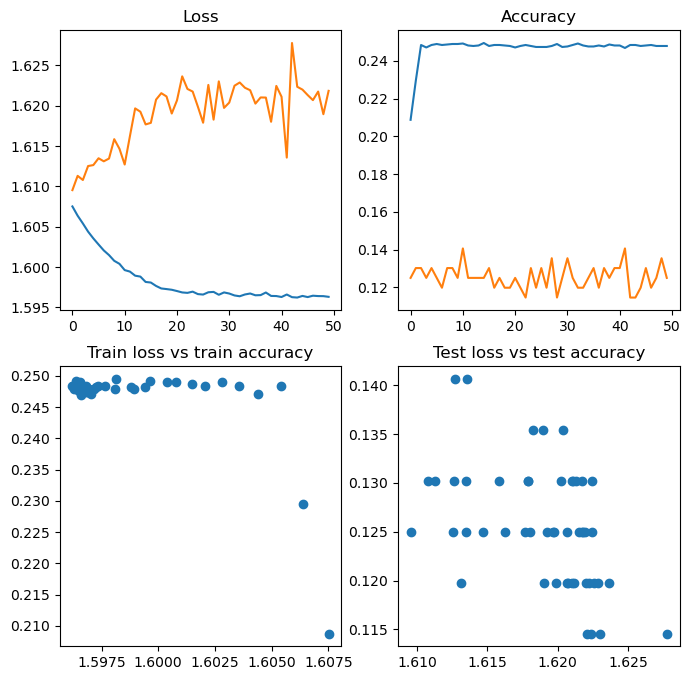

In [395]:
model_5_all_results = pd.concat([
    pd.DataFrame(model_5_results),
    pd.DataFrame(model_5_results1),
    pd.DataFrame(model_5_results2)])
plot_model_results(model_5_all_results, figsize=8)

In [389]:
torch.cuda.is_available()

False

### Reducing data to 2 categories only

**Manually moved 3 categories of data**

Fitting the model as follows:
1. start with 2 categories only
2. add 1 additional category at a time and replace the classifier of the model

This way of fitting the model appears to work, though now there seem to be an issue with overfitting. After trying 10 epochs for each additional category, I noticed that the test loss started to increase and the test accuracy was stable a clear sign of overfitting.

I fitted the model again, however after tuning the parameters with 2 categories I switch off the gradients of the convolutional layers and let only the linear layers to be changed.

#### Preparing the data

In [225]:
# moving 3 folders to a different location to reduce the number of categories
import shutil
import os
from pathlib import Path
    
source_dir = ['train/rose/', 'train/sunflower/', 'train/tulip/']
target_dir = ['rose/', 'sunflower/', 'tulip/']

# create directory if they don't exist
for directory in target_dir:
    Path(directory).mkdir(parents=True, exist_ok=True)

for directory in range(3):
    if len(os.listdir(Path(target_dir[directory]))) == 0:
        file_names = os.listdir(source_dir[directory])
        print(len(file_names))
        print(f"{target_dir[directory]} is empty, moving files")
        for file_name in file_names:
            shutil.move(os.path.join(Path(source_dir[directory]), file_name), Path(target_dir[directory]))
        os.rmdir(Path(source_dir[directory]))


497
rose/ is empty, moving files
495
sunflower/ is empty, moving files
607
tulip/ is empty, moving files


In [227]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

In [228]:
os.getcwd()

'/Users/neddacecchinato/Documents/Python/flowers_five_classes'

In [231]:
# import datasets
data = datasets.ImageFolder(root="train",
                            transform=data_transform, # transform for the data
                            target_transform=None)

In [232]:
torch.manual_seed(100)
train_data, test_data = train_test_split(data, test_size=0.2)
len(train_data), len(test_data)

(917, 230)

In [233]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)
len(train_dataloader)

29

#### Fitting VGG11 with 2 categories only

In [235]:
model_6 = VGG11architecture(classes=2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_6.parameters(),
                            lr=0.001)

In [236]:
m6_start_time = timer()
model_6_results = train(model_6,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        epochs=10,
                        device=device)
m6_end_time = timer()
print((m6_end_time-m6_start_time)/60)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train loss: 0.73001 | Train acc: 0.50564 | Test loss: 0.67978 | Test acc: 0.61979
Epoch: 2
Train loss: 0.68967 | Train acc: 0.54233 | Test loss: 0.68246 | Test acc: 0.60286
Epoch: 3
Train loss: 0.79579 | Train acc: 0.55357 | Test loss: 0.65923 | Test acc: 0.60286
Epoch: 4
Train loss: 0.72986 | Train acc: 0.54772 | Test loss: 0.67951 | Test acc: 0.61979
Epoch: 5
Train loss: 0.69477 | Train acc: 0.56876 | Test loss: 0.68265 | Test acc: 0.58594
Epoch: 6
Train loss: 0.68810 | Train acc: 0.55357 | Test loss: 0.68463 | Test acc: 0.55208
Epoch: 7
Train loss: 0.67336 | Train acc: 0.55639 | Test loss: 0.64926 | Test acc: 0.61979
Epoch: 8
Train loss: 0.64207 | Train acc: 0.56825 | Test loss: 0.65385 | Test acc: 0.58854
Epoch: 9
Train loss: 0.59096 | Train acc: 0.69279 | Test loss: 0.61097 | Test acc: 0.61458
Epoch: 10
Train loss: 0.48475 | Train acc: 0.79736 | Test loss: 0.49203 | Test acc: 0.75000
9.416994275699835


#### Extend to 3 categories: keeping conv layer estimation

In [175]:
# moving files back into train functions (they are moved away for a smaller model later in the code)
directory = Path('rose/')
Path('train' / directory).mkdir(parents=True, exist_ok=True)

if len(os.listdir(Path('train' / directory))) == 0:
    file_names = os.listdir(Path(directory))
    print(len(file_names))
    # print(f"{target_dir[directory]} is empty, moving files")
    for file_name in file_names:
        shutil.move(os.path.join(Path(directory), file_name), Path('train' / directory))
        # os.rmdir(Path(source_dir[directory]))

497


In [ ]:
# import datasets
data = datasets.ImageFolder(root="train",
                            transform=data_transform, # transform for the data
                            target_transform=None)

torch.manual_seed(100)
train_data, test_data = train_test_split(data, test_size=0.2)
len(train_data), len(test_data)

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)
len(train_dataloader)

In [191]:
model_6.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 3)).to(device)

In [193]:
# model_6 = VGG11architecture(classes=2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_6.parameters(),
                            lr=0.001)

In [194]:
m6_start_time = timer()
model_6_results = train(model_6,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        epochs=10,
                        device=device)
m6_end_time = timer()
print((m6_end_time-m6_start_time)/60)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train loss: 0.78759 | Train acc: 0.65923 | Test loss: 0.68646 | Test acc: 0.71686
Epoch: 2
Train loss: 0.58901 | Train acc: 0.75595 | Test loss: 0.53799 | Test acc: 0.82102
Epoch: 3
Train loss: 0.52744 | Train acc: 0.80432 | Test loss: 0.54751 | Test acc: 0.81250
Epoch: 4
Train loss: 0.44810 | Train acc: 0.82738 | Test loss: 0.48179 | Test acc: 0.82670
Epoch: 5
Train loss: 0.41221 | Train acc: 0.85565 | Test loss: 0.52077 | Test acc: 0.82670
Epoch: 6
Train loss: 0.39982 | Train acc: 0.85863 | Test loss: 0.53295 | Test acc: 0.83649
Epoch: 7
Train loss: 0.37852 | Train acc: 0.86756 | Test loss: 0.51895 | Test acc: 0.82102
Epoch: 8
Train loss: 0.39210 | Train acc: 0.85541 | Test loss: 0.88431 | Test acc: 0.80777
Epoch: 9
Train loss: 0.41844 | Train acc: 0.84474 | Test loss: 0.54837 | Test acc: 0.80366
Epoch: 10
Train loss: 0.39291 | Train acc: 0.86533 | Test loss: 0.49388 | Test acc: 0.82513
7.634038634033641


#### Extend to 4 categories

In [199]:
# moving files back into train functions (they are moved away for a smaller model later in the code)
directory = Path('sunflower/')
Path('train' / directory).mkdir(parents=True, exist_ok=True)

if len(os.listdir(Path('train' / directory))) == 0:
    file_names = os.listdir(Path(directory))
    print(len(file_names))
    # print(f"{target_dir[directory]} is empty, moving files")
    for file_name in file_names:
        shutil.move(os.path.join(Path(directory), file_name), Path('train' / directory))
        # os.rmdir(Path(source_dir[directory]))

495


In [203]:
# import datasets
data = datasets.ImageFolder(root="train",
                            transform=data_transform, # transform for the data
                            target_transform=None)

torch.manual_seed(100)
train_data, test_data = train_test_split(data, test_size=0.2)
print(len(train_data), len(test_data))

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)
len(train_dataloader)

1711 428


54

In [205]:
model_6.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4)).to(device)

In [ ]:
# turning off the gradient means that they won't update anymore
for param in model_6.convlayers.parameters():
  param.requires_grad = False

In [206]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_6.parameters(),
                            lr=0.001)

In [209]:
m6_start_time = timer()
model_6_results = train(model_6,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        epochs=10,
                        device=device)
m6_end_time = timer()
print((m6_end_time-m6_start_time)/60)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train loss: 0.94279 | Train acc: 0.63171 | Test loss: 0.63789 | Test acc: 0.75074
Epoch: 2
Train loss: 0.63338 | Train acc: 0.77508 | Test loss: 0.68198 | Test acc: 0.75223
Epoch: 3
Train loss: 0.57405 | Train acc: 0.78696 | Test loss: 0.58223 | Test acc: 0.80506
Epoch: 4
Train loss: 0.47657 | Train acc: 0.82971 | Test loss: 0.59695 | Test acc: 0.78943
Epoch: 5
Train loss: 0.40834 | Train acc: 0.84352 | Test loss: 0.74148 | Test acc: 0.75595
Epoch: 6
Train loss: 0.31307 | Train acc: 0.89105 | Test loss: 0.89001 | Test acc: 0.75372
Epoch: 7
Train loss: 0.26828 | Train acc: 0.89757 | Test loss: 0.73764 | Test acc: 0.76935
Epoch: 8
Train loss: 0.31991 | Train acc: 0.89055 | Test loss: 0.71981 | Test acc: 0.78051
Epoch: 9
Train loss: 0.30218 | Train acc: 0.89931 | Test loss: 0.62984 | Test acc: 0.79018
Epoch: 10
Train loss: 0.25325 | Train acc: 0.90783 | Test loss: 0.72716 | Test acc: 0.79464
9.966084869450423


#### Extend to 5 categories

In [211]:
# moving files back into train functions (they are moved away for a smaller model later in the code)
directory = Path('tulip/')
Path('train' / directory).mkdir(parents=True, exist_ok=True)

if len(os.listdir(Path('train' / directory))) == 0:
    file_names = os.listdir(Path(directory))
    print(len(file_names))
    # print(f"{target_dir[directory]} is empty, moving files")
    for file_name in file_names:
        shutil.move(os.path.join(Path(directory), file_name), Path('train' / directory))
        # os.rmdir(Path(source_dir[directory]))

607


In [212]:
# import datasets
data = datasets.ImageFolder(root="train",
                            transform=data_transform, # transform for the data
                            target_transform=None)

torch.manual_seed(100)
train_data, test_data = train_test_split(data, test_size=0.2)
print(len(train_data), len(test_data))

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)
len(train_dataloader)

2196 550


69

In [213]:
model_6.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 5)).to(device)

In [214]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_6.parameters(),
                            lr=0.001)

In [215]:
m6_start_time = timer()
model_6_results = train(model_6,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        epochs=10,
                        device=device)
m6_end_time = timer()
print((m6_end_time-m6_start_time)/60)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train loss: 0.96185 | Train acc: 0.60761 | Test loss: 0.75766 | Test acc: 0.69155
Epoch: 2
Train loss: 0.70204 | Train acc: 0.71558 | Test loss: 0.83074 | Test acc: 0.67998
Epoch: 3
Train loss: 0.58963 | Train acc: 0.77065 | Test loss: 0.83430 | Test acc: 0.72106
Epoch: 4
Train loss: 0.55436 | Train acc: 0.78967 | Test loss: 0.89252 | Test acc: 0.68981
Epoch: 5
Train loss: 0.45113 | Train acc: 0.82926 | Test loss: 1.02631 | Test acc: 0.69850
Epoch: 6
Train loss: 0.31839 | Train acc: 0.87889 | Test loss: 1.07834 | Test acc: 0.66551
Epoch: 7
Train loss: 0.31339 | Train acc: 0.89692 | Test loss: 1.29297 | Test acc: 0.67998
Epoch: 8
Train loss: 0.34952 | Train acc: 0.88705 | Test loss: 1.40405 | Test acc: 0.69213
Epoch: 9
Train loss: 0.22184 | Train acc: 0.92745 | Test loss: 1.29007 | Test acc: 0.72859
Epoch: 10
Train loss: 0.23943 | Train acc: 0.92998 | Test loss: 1.85815 | Test acc: 0.65509
12.72297657361681


## VGG11 transfer learning -**success**-

1. Load weights
2. Load model with weights
3. Freeze all weights, except last layer
4. Replace classifier
5. Import data and apply proper transformation (e.g. normalization)
6. Create dataloaders


In [49]:
import torchvision

In [ ]:
weights = torchvision.models.VGG11_Weights.IMAGENET1K_V1

In [83]:
model_6 = torchvision.models.vgg11(weights=weights).to(device)

In [85]:
print(next(model_6.parameters()).is_mps)

True


In [86]:
for param in model_6.features.parameters():
  param.requires_grad = False

In [87]:
model_6.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [88]:
model_6.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features = 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features = 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features = 5)).to(device)
model_6.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=5, bias=True)
)

In [90]:
from torchvision import transforms

normalise = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalise])

In [91]:
data = datasets.ImageFolder(root="train",
                            transform=manual_transforms, # transform for the data
                            target_transform=None)

In [95]:
class_names = data.classes
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [100]:
train_data, test_data = train_test_split(data, test_size=0.2)

In [101]:
torch.manual_seed(100)
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)
len(train_dataloader)

69

In [102]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_6.parameters(),
                             lr=0.0001)

In [103]:
# from torchinfo import summary

# # Print a summary using torchinfo (uncomment for actual output)
# summary(model=model_6, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

In [104]:
device

'mps'

In [105]:
m6_start_time = timer()
model_6_results = train(model_6,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        epochs=5,
                        device=device)
m6_end_time = timer()
print((m6_end_time-m6_start_time)/60)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train loss: 0.63463 | Train acc: 0.76411 | Test loss: 0.31496 | Test acc: 0.89211
Epoch: 2
Train loss: 0.11998 | Train acc: 0.95879 | Test loss: 0.30191 | Test acc: 0.89931
Epoch: 3
Train loss: 0.04206 | Train acc: 0.98868 | Test loss: 0.28255 | Test acc: 0.92014
Epoch: 4
Train loss: 0.01110 | Train acc: 0.99864 | Test loss: 0.34931 | Test acc: 0.91567
Epoch: 5
Train loss: 0.01322 | Train acc: 0.99909 | Test loss: 0.28883 | Test acc: 0.90699
2.369918132632544


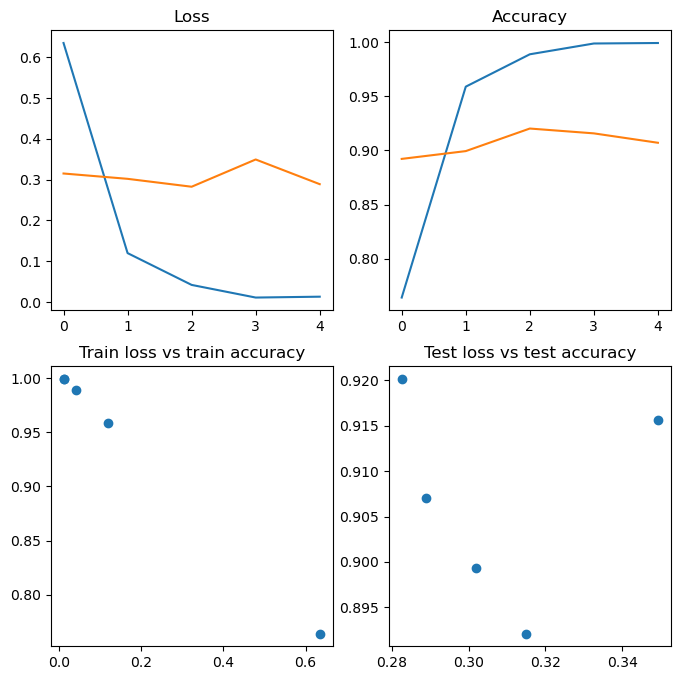

In [117]:
plot_model_results(pd.DataFrame(model_6_results),8)

In [119]:
import random

In [121]:
len(test_data)

551

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


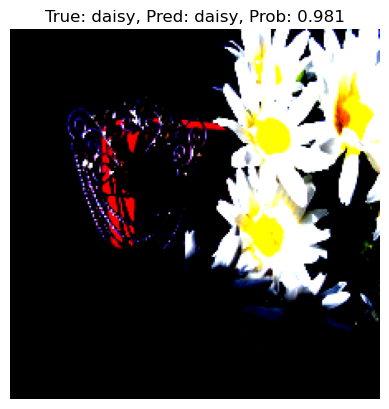

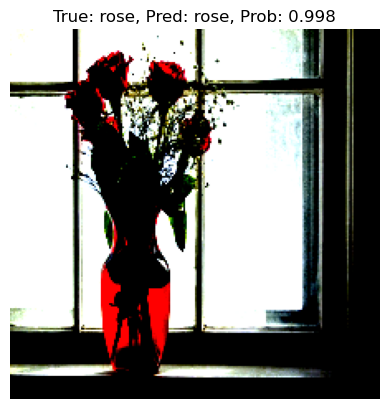

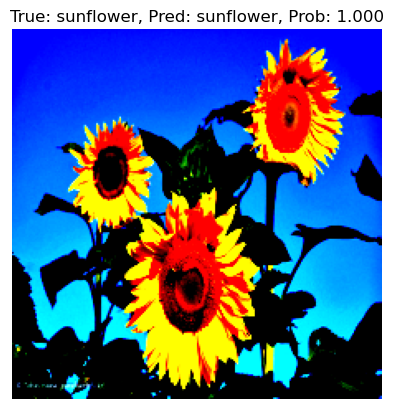

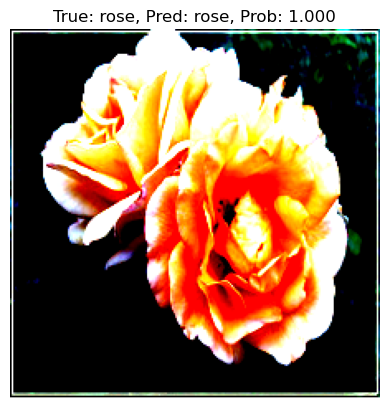

In [142]:
plot_random_test(model_6,
                 test_data,
                 class_names,
                 # total_pictures: int=4,
                 device=device)

## Tiny VGG version 2 (archived not-working)

In [ ]:
class TinyVGG2(nn.Module):
  def __init__(self,
               in_feature: int,
               hidden_units: int,
               output_features: int,
               remaining_dimensions: int):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=in_feature,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*remaining_dimensions*remaining_dimensions,
                  out_features=output_features)
    )

  def forward(self, x):
    return self.classifier(
        self.conv_block2(self.conv_block1(x)))

In [ ]:
model_3 = TinyVGG2(3, 10, 5, 11)
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

In [ ]:
model_3_results = train(model_3,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=60)

model_3_results_total = pd.DataFrame(model_3_results)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6066 | train_acc: 0.2257 | test_loss: 1.6019 | test_acc: 0.2344
Epoch: 2 | train_loss: 1.6054 | train_acc: 0.2216 | test_loss: 1.5992 | test_acc: 0.2500
Epoch: 3 | train_loss: 1.6047 | train_acc: 0.2285 | test_loss: 1.5969 | test_acc: 0.2500
Epoch: 4 | train_loss: 1.5987 | train_acc: 0.2298 | test_loss: 1.6211 | test_acc: 0.2523
Epoch: 5 | train_loss: 1.6001 | train_acc: 0.2380 | test_loss: 1.5975 | test_acc: 0.2500
Epoch: 6 | train_loss: 1.6053 | train_acc: 0.2190 | test_loss: 1.5977 | test_acc: 0.2500
Epoch: 7 | train_loss: 1.6050 | train_acc: 0.2284 | test_loss: 1.5989 | test_acc: 0.2500
Epoch: 8 | train_loss: 1.6049 | train_acc: 0.2282 | test_loss: 1.5978 | test_acc: 0.2344
Epoch: 9 | train_loss: 1.6052 | train_acc: 0.2162 | test_loss: 1.5975 | test_acc: 0.2500
Epoch: 10 | train_loss: 1.6052 | train_acc: 0.2254 | test_loss: 1.5989 | test_acc: 0.2500
Epoch: 11 | train_loss: 1.6052 | train_acc: 0.2216 | test_loss: 1.5996 | test_acc: 0.2500
Epoch: 12 | train_l

In [ ]:
model_4 = TinyVGG2(3, 10, 5, 11)
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

In [ ]:
model_4_results = train(model_4,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=60)

model_4_results_total = pd.DataFrame(model_4_results)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6089 | train_acc: 0.2282 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 2 | train_loss: 1.6089 | train_acc: 0.2279 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 3 | train_loss: 1.6089 | train_acc: 0.2287 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 4 | train_loss: 1.6088 | train_acc: 0.2290 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 5 | train_loss: 1.6089 | train_acc: 0.2279 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 6 | train_loss: 1.6089 | train_acc: 0.2279 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 7 | train_loss: 1.6088 | train_acc: 0.2290 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 8 | train_loss: 1.6089 | train_acc: 0.2284 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 9 | train_loss: 1.6089 | train_acc: 0.2287 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 10 | train_loss: 1.6089 | train_acc: 0.2284 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 11 | train_loss: 1.6089 | train_acc: 0.2282 | test_loss: 1.6066 | test_acc: 0.2500
Epoch: 12 | train_l

In [ ]:
model_5 = TinyVGG2(3, 10, 5, 11)
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

In [ ]:
model_5_results = train(model_5,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn=loss_fn,
                        epochs=60)
model_5_results_total = pd.DataFrame(model_5_results)

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6094 | train_acc: 0.1851 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 2 | train_loss: 1.6093 | train_acc: 0.1851 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 3 | train_loss: 1.6093 | train_acc: 0.1857 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 4 | train_loss: 1.6093 | train_acc: 0.1857 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 5 | train_loss: 1.6093 | train_acc: 0.1862 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 6 | train_loss: 1.6092 | train_acc: 0.1857 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 7 | train_loss: 1.6093 | train_acc: 0.1857 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 8 | train_loss: 1.6093 | train_acc: 0.1849 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 9 | train_loss: 1.6093 | train_acc: 0.1851 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 10 | train_loss: 1.6095 | train_acc: 0.1849 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 11 | train_loss: 1.6093 | train_acc: 0.1851 | test_loss: 1.6060 | test_acc: 0.1707
Epoch: 12 | train_l

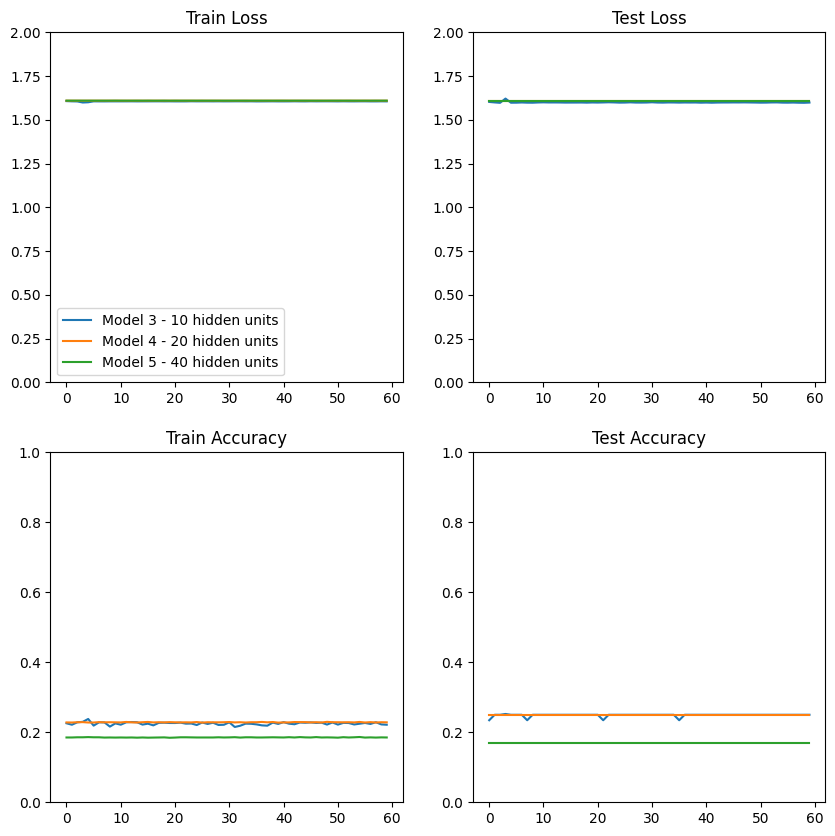

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(range(len(model_3_results_total["train_loss"])), model_3_results_total["train_loss"], label="Model 3 - 10 hidden units")
plt.plot(range(len(model_4_results_total["train_loss"])), model_4_results_total["train_loss"], label="Model 4 - 20 hidden units")
plt.plot(range(len(model_5_results_total["train_loss"])), model_5_results_total["train_loss"], label="Model 5 - 40 hidden units")
plt.legend()
plt.ylim(0, 2)
plt.title("Train Loss")

plt.subplot(2, 2, 2)
plt.plot(range(len(model_3_results_total["train_loss"])), model_3_results_total["test_loss"])
plt.plot(range(len(model_4_results_total["train_loss"])), model_4_results_total["test_loss"])
plt.plot(range(len(model_5_results_total["train_loss"])), model_5_results_total["test_loss"])
plt.ylim(0, 2)
plt.title("Test Loss")

plt.subplot(2, 2, 3)
plt.plot(range(len(model_3_results_total["train_loss"])), model_3_results_total["train_acc"])
plt.plot(range(len(model_4_results_total["train_loss"])), model_4_results_total["train_acc"])
plt.plot(range(len(model_5_results_total["train_loss"])), model_5_results_total["train_acc"])
plt.ylim(0, 1)
plt.title("Train Accuracy");

plt.subplot(2, 2, 4)
plt.plot(range(len(model_3_results_total["train_loss"])), model_3_results_total["test_acc"])
plt.plot(range(len(model_4_results_total["train_loss"])), model_4_results_total["test_acc"])
plt.plot(range(len(model_5_results_total["train_loss"])), model_5_results_total["test_acc"])
plt.ylim(0, 1)
plt.title("Test Accuracy");

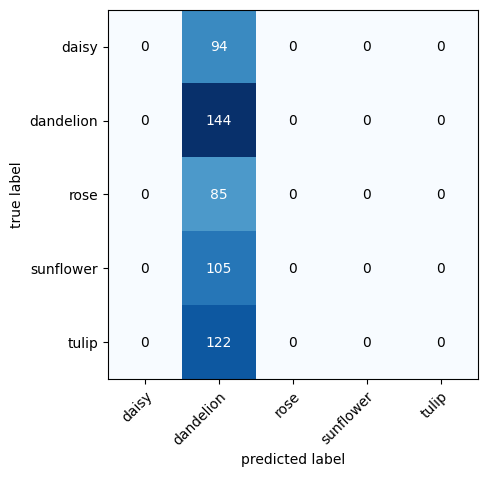

In [ ]:
confusion_matrix_plot(model_3,
                      test_dataloader,
                      class_names)

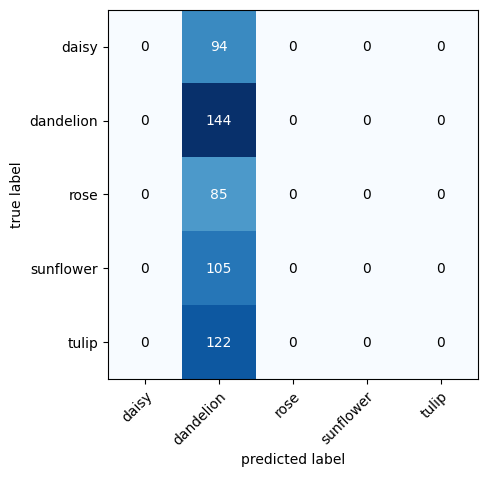

In [ ]:
confusion_matrix_plot(model_4,
                      test_dataloader,
                      class_names)

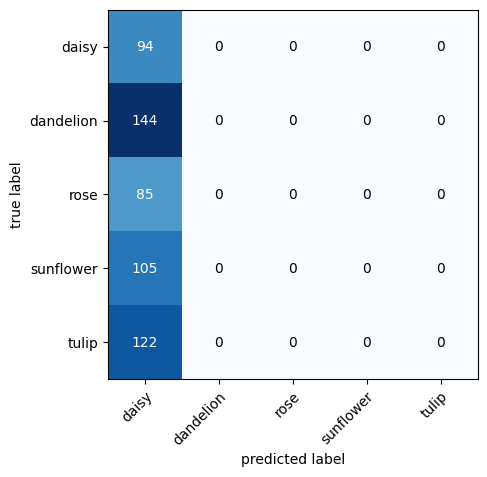

In [ ]:
confusion_matrix_plot(model_5,
                      test_dataloader,
                      class_names)